# A computational building block approach towards multiscale architected materials analysis and design with application to hierarchical metal metamaterials    

### Markus J. Buehler
email: mbuehler@mit.edu  

Abstract: In this study we report a computational approach towards multiscale architected materials analysis and design. A particular challenge in modeling and simulation of materials, and especially the development of hierarchical design approaches, has been to identify ways by which complex multi-level material structures can be effectively modeled. One way to achieve this is to use coarse-graining approaches, where  physical relationships can be effectively described with reduced dimensionality. In this paper we report an integrated deep neural network architecture that first learns coarse-grained representations of complex hierarchical microstructure data via a discrete variational autoencoder and then utilizes an attention-based diffusion model solve both forward and inverse problems, including a capacity to solve degenerate design problems. As an application, we demonstrate the method in the analysis and design of hierarchical highly porous metamaterials within the context of nonlinear stress-strain responses to compressive deformation.  We validate the mechanical behavior and mechanisms of deformation using embedded-atom molecular dynamics simulations carried out for copper and nickel, showing good agreement with the design objectives.  

##### Reference: 

[1] M. Buehler, A computational building block approach towards multiscale architected materials analysis and design with application to hierarchical metal metamaterials , Modelling and Simulation in Materials Science and Engineering, 2023 


### This code consists of 3 models

This code consists of three models: Model 1 (VQ-VAE to encode hierarchical architected microstructures), Model 2 (diffusion model to predict hierarchical architected microstructures from a stress-strain response conditioning), and Model 3 (diffusion model to predict stress-strain response from a microstructure)

## Model 2: Generative attention-diffusion model

In [1]:
import os,sys
import math
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import shutil

In [2]:
from torchvision.utils import save_image, make_grid

In [3]:
import torch

from sklearn.model_selection import train_test_split

In [4]:
from HierarchicalDesign import VectorQuantize, VQVAEModel, Encoder_Attn ,Decoder_Attn,count_parameters
from HierarchicalDesign import get_fmap_from_codebook

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

device='cuda:0'

num_of_gpus = torch.cuda.device_count()
print(num_of_gpus)

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

1


In [6]:
device

'cuda:0'

In [7]:
print("Torch version:", torch.__version__) 

Torch version: 2.0.0+cu117


### Load libraries, define parameters, etc.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

#from tqdm import tqdm
from tqdm.autonotebook import tqdm

from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import ast
import pandas as pd
import numpy as np
from einops import rearrange 
 
from torch.utils.data import DataLoader,Dataset
from torchvision.io import read_image
import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image
import time
to_pil = transforms.ToPILImage()

from torchvision.utils import save_image, make_grid

### Define and load VQ-VAE

In [10]:
#Define hyperpamaters
batch_size_=16

im_res_VAE=512 
im_res_final=im_res_VAE

###########
hidden_dim = 16   #this is how much depth the sequence will have

num_codebook_vectors=128 
embedding_dim = 256 #for codebook

output_dim = 3
input_dim = 3

chann_enc=  [64, 64, 64, 128, 128, 128, 256, 256]  
chann_dec= [256, 256, 256, 128, 64, 64, 64] 

codebook = VectorQuantize(
            dim = hidden_dim,
            codebook_dim = embedding_dim,
            codebook_size = num_codebook_vectors,
            decay = 0.9,
            commitment_weight = 1.,
            kmeans_init = True,
            accept_image_fmap = True,
            use_cosine_sim = True,
            orthogonal_reg_weight = 2., #0.
        )

###########################################################################
encoder = Encoder_Attn( image_channels=input_dim, latent_dim=hidden_dim,
                      channels = chann_enc, 
                      start_resolution_VAE_encoder=512,
                 attn_resolutions_VAE_encoder = [16],
                 num_res_blocks_encoder=2,
                      )
decoder = Decoder_Attn( image_channels=input_dim, latent_dim=hidden_dim, 
                       channels = chann_dec,
                       attn_resolutions_VAE_decoder=[16],
                 start_resolution_VAE_decoder= 16, 
                 num_res_blocks_VAE_decoder=3,
                      )
###########################################################################
VQVAEmodel = VQVAEModel(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(device)
count_parameters(VQVAEmodel)

Final resolution of encoder (must be start resolution of decoder):  16
Final resolution of decoder:  512
----------------------------------------------------------------------------------------------------
Total parameters:  28904291  trainable parameters:  28904291
----------------------------------------------------------------------------------------------------


#### Test VQ-VAE and define some variables 

In [11]:
#Test model and shapes
print ("Image resolution: ", im_res_VAE,  "x", im_res_VAE)
images = torch.randn(4, 3, im_res_VAE, im_res_VAE).cuda()

with torch.no_grad():
    z, indices  =  VQVAEmodel.encode_z(images, )
print ("z ", z.shape )
print ("infices ", indices.shape)

with torch.no_grad():
    images_hat =  VQVAEmodel.decoder(z,  )
print ("image  snapped shape ", images_hat.shape)

with torch.no_grad():
    images_hat_snapped, z_quant =  VQVAEmodel.decode_snapped(z,  )

    print ("image_hat snapped shape ", images_hat_snapped.shape)
print ("z quant ", z_quant.shape)

size_VAE=z.shape [1]
z_reshaped=torch.reshape(z, (z.shape[0],z.shape[1],z.shape[2]**2))

fmap_lin = z.shape[2]
print (f"VAE will produce sequences of shape (b,  {z_reshaped.shape})")

Image resolution:  512 x 512
z  torch.Size([4, 16, 8, 8])
infices  torch.Size([4, 8, 8])
image  snapped shape  torch.Size([4, 3, 512, 512])
image_hat snapped shape  torch.Size([4, 3, 512, 512])
z quant  torch.Size([4, 16, 8, 8])
VAE will produce sequences of shape (b,  torch.Size([4, 16, 64]))


In [12]:
VQVAEmodel.load_state_dict(torch.load(f'./VQ_VAE_results/model-epoch_128.pt'))

<All keys matched successfully>

In [13]:
def sample_VAE (model, test_loader, samples = 16, fname1 = None, fname2 = None):
    model.eval()

    with torch.no_grad():

        for batch_idx, (_, x) in enumerate(tqdm(test_loader)):

            x = x.to(device)
        
            x_hat, indices, commitment_loss,    = model(x)

            with torch.no_grad():
                x_enc =model.encode(x)
            
            with torch.no_grad():
                z, indices=model.encode_z(x)
            
            with torch.no_grad():
                x_hat_snapped, z_quant =  model.decode_snapped(z,  )

            break
    samples= min([samples, x.shape[0]])
    
    x_hat=unscale_image(x_hat)
    x_hat_snapped=unscale_image(x_hat)
    x=unscale_image(x)

    draw_sample_image(x[:samples], "Ground-truth images", fname1)
    draw_sample_image(x_hat[:samples], "Reconstructed images", fname2)
    draw_sample_image(x_hat_snapped[:samples], "Reconstructed images, snapped", fname2)
        
    return
    

In [14]:
def draw_sample_image(x, postfix, fname=None, dpi=600,padding=0):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=padding, normalize=True), (1, 2, 0)))
    if fname != 0:
        plt.savefig(fname, dpi=dpi)
    plt.show()

### Load dataset

In [15]:
from torch.utils.data import DataLoader,Dataset
import pandas as pd
import seaborn as sns

In [16]:
 
import torchvision
 
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image, make_grid

from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from functools import partial, wraps

In [17]:

print("Torch version:", torch.__version__) 

Torch version: 2.0.0+cu117


In [18]:

from sklearn.preprocessing import RobustScaler

In [19]:
from PIL import Image
import ast
import pandas as pd
import numpy as np

def scale_image(image2):
    return image2 * 2. - 1.0
 
def unscale_image(image2):
    image2=(image2 +1. )/ 2. 
    image2=image2.clamp(0, 1)
    return image2

# First - not used: Image to image
data_dir = '../'
class ImageDataset_ImagePairs(Dataset):
    def __init__(self,X_data,paths2,transform):
       
        self.X_data = X_data
        
        self.paths2=list(paths2)
        self.transform=transform

    def __len__(self):
        return len(self.paths2)

    def __getitem__(self,index):
        
        image1= self.X_data[index]
       
        im2_pil = Image.open(data_dir+self.paths2[index]).convert('RGB')#Image.fromarray(image2)

        image2=self.transform(im2_pil)
        image2=scale_image(image2)    
      
        return (image1, image2)
    
def ImagePairs_load_split_train_test(csvfile, valid_size = .2, im_res=256, batch_size_=16, max_l=32,
                                    X_min=None, X_max=None):
    train_transforms = transforms.Compose([#transforms.RandomRotation(30),  # data augmentations are great
                                       #transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                       #transforms.RandomHorizontalFlip(),
                                        transforms.RandomHorizontalFlip(),
                                        #transforms.RandomVerticalFlip(),
                                    transforms.Resize((im_res,im_res)),
                                           #transforms.Normalize([0.485, 0.456, 0.406],  
                                           #                  [0.229, 0.224, 0.225]),
                                       transforms.ToTensor(),
                                           #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                           #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                       ])
    test_transforms = transforms.Compose([#transforms.RandomRotation(30),  # data augmentations are great
                                       #transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                        transforms.RandomHorizontalFlip(),
                                       # transforms.RandomVerticalFlip(),
                                        #transforms.RandomHorizontalFlip(),
                                        transforms.Resize((im_res,im_res)),
                                           #transforms.Normalize([0.485, 0.456, 0.406],  
                                           #                  [0.229, 0.224, 0.225]),
                                       #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                       transforms.ToTensor(),
                                          # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                          #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                       ])

    df=pd.read_csv(csvfile)
     
    imgpair=df["microstructure"]
    
    x=df['stresses']

    xs=[]
    for xi in x:
        xentry=ast.literal_eval(xi)
        xs.append(xentry[:max_l])
    X=np.asarray(xs)

    if X_min==None:
        X_min=np.min(X)
    else:
        print ("use provided X_min", X_min)
    if X_max==None:
        X_max=np.max(X)
    else:
        print ("use provided X_max", X_max)
    
    X=(X-X_min)/(X_max-X_min)*2-1 #Normalize range -1 to 1
    
    print ("Check X after norm  ", np.min(X), np.max(X))
    
    X=torch.from_numpy(X).float()
    if valid_size>0:
       
        X_train, X_test, y_train, y_test =train_test_split(X,imgpair,test_size=valid_size, random_state=451)
    else:
        train_dataset = ImageDataset_ImagePairs(X, imgpair,test_transforms)
        trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size_, shuffle=False)
      
        return trainloader, None, X_max, X_min
    
    train_data=ImageDataset_ImagePairs(X_train,y_train,train_transforms)
    test_data=ImageDataset_ImagePairs(X_test,y_test,test_transforms)
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_)

    testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_)
    return trainloader, testloader, X_max, X_min

csvfile = './shc_09_raw_wimagename_5_thick.csv'

train_loader, test_loader, X_max, X_min = ImagePairs_load_split_train_test(csvfile, .1, 
                                                                           im_res=im_res_final,
                                                                           batch_size_=batch_size_, 
                                                                           max_l=32)

print ("Number of training batches: ", len(train_loader), "batch size= ", batch_size_, "total: ",len(train_loader)*batch_size_ )
print ("Number of test batches: ", len(test_loader), "batch size= ", batch_size_, "total: ",len(test_loader)*batch_size_)

print("TOTAL images (account for full batches): ", len(train_loader)*batch_size_+len(test_loader)*batch_size_ )

print ("X_max", X_max, "X_min ", X_min)
 

Check X after norm   -1.0 1.0
Number of training batches:  82 batch size=  16 total:  1312
Number of test batches:  10 batch size=  16 total:  160
TOTAL images (account for full batches):  1472
X_max 1.42978730046296 X_min  -0.0086872168352131


  0%|          | 0/10 [00:00<?, ?it/s]

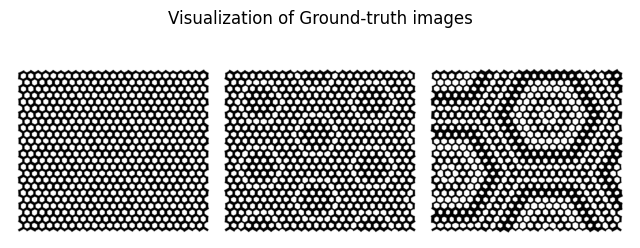

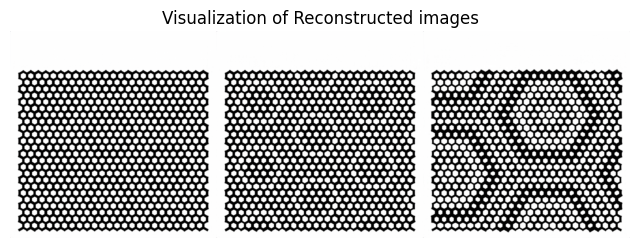

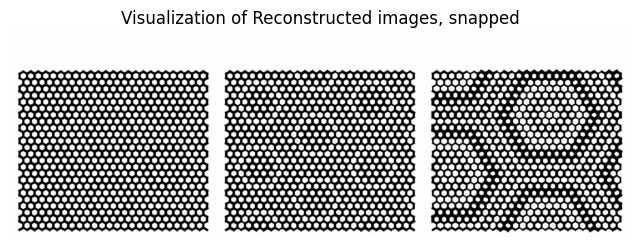

In [20]:
sample_VAE (VQVAEmodel, test_loader, fname1 =f'or_test.png', fname2=f'rec_test.png',samples = 3)

### Build diffusion model

## Training loop

In [21]:
#from pytorch_lightning.utilities.seed import seed_everything
#from pytorch_lightning.utilities.seed import reset_seed, isolate_rng

In [23]:
def sample_sequence (model,
                X=[[10, 10, 8, 3, 13, 13, 14, 7, 3, 10 ]],
                 flag=0,
                     cond_scales=1.,foldproteins=False,
                     seed=None,plot_original_data=False,GT =None,
               ):
    steps=0
    e=flag

    if seed !=None:
        print ("Set seed to: ", seed)
        seed_everything(seed)
    
    print (f"Producing {len(X)} samples...")
    
    X=torch.Tensor(X)
    X=(X-X_min)/(X_max-X_min)*2-1 #Normalize range -1 to 1
    for iisample in range (len (X)):
        
        
        
        X_cond= (X[iisample] ).to(device).unsqueeze (0)
        
        print (X_cond.shape)
        result=model.sample ( X_cond,stop_at_unet_number=train_unet_number ,
                                 cond_scale=cond_scales )
            
      
        if plot_original_data:
            
            cond_unscaled=(X_cond[0,:].cpu().detach().numpy()+1)/2.*(X_max-X_min)+X_min
            
            plt.plot (cond_unscaled,label= f'Required stress-strain data')
            plt.ylim ((0, 1.1))
            #plt.plot (GT[samples,0,:],label= f'GT {0}')
            plt.legend()
            
            fname4= prefix+ f"input_to_samples_{e}_{steps}.jpg"
            plt.savefig(fname4, dpi=300)   
            plt.show()
    
       
        result=torch.reshape(result, (result.shape[0],result.shape[1], sqer_z,sqer_z))
        
        model.imagen.VAE.eval()
        with torch.no_grad():
            
            result,_ =  model.imagen.VAE.decode_snapped(result,  )
            result=unscale_image(result)
        

        fname2=prefix+ f"sampld_from_X_{flag}_condscale-{str (cond_scales)}_{e}_{steps}.jpg"
        

        draw_sample_image(result[0,:], "Predicted microstructure", fname2)  

 
        steps=steps+1
       
    reset_seed()

In [24]:
def draw_sample_image(x, postfix, fname=None):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=0, normalize=True), (1, 2, 0)))
    if fname != None:
        plt.savefig(fname, dpi=300)
    plt.show()

In [25]:
def sample_loop (model,
                train_loader,
                cond_scales=[7.5], #list of cond scales - each sampled...
                num_samples=2, #how many samples produced every time tested.....
                 
                 flag=0,foldproteins=False,
                  seed=None,save_ind_files=False,
                 plot_structure=False,plot_original_data=False,do_forward=False,number_batches=1,strain=None,
                 csv_for_data=None,
                 mix_bernouilli=False, bernouilli_prob=0.5, #if True sample two solutions and mix accordig to Bernouilli
                 #init_images=None,
                 repeat_sampling=1,
               ):
    steps=0
    e=flag
    
    if seed !=None:
        print ("Set seed to: ", seed)
        seed_everything(seed)
    if csv_for_data!=None:
        print ("Open CSV file to save...", csv_for_data)
        stresses_list =[]
        image_list =[]
        
    for item  in train_loader:

            X_train_batch= item[0].to(device)
            y_train_batch=item[1].to(device)

            GT=y_train_batch.cpu().detach() 
            
            print (X_train_batch.shape, y_train_batch.shape)
            num_samples = min (num_samples,y_train_batch.shape[0] )
            print (f"Producing {num_samples} samples..., batch size ={y_train_batch.shape[0]}")
 
            for iisample in range (len (cond_scales)):
        
                cond_unscaled=(X_train_batch.cpu().detach().numpy()+1)/2.*(X_max-X_min)+X_min
            
                
                result=model.sample ( X_train_batch,stop_at_unet_number=train_unet_number ,
                                         cond_scale=cond_scales[iisample])
                
                if repeat_sampling>1:
                    print (f"Repeat sampling {repeat_sampling} times")
                    for irep in range (repeat_sampling-1):
                        print (f"Repeat {irep}")
                        result=model.sample ( X_train_batch,stop_at_unet_number=train_unet_number ,
                                             cond_scale=cond_scales[iisample],
                                            init_images=result)
                print (result.shape)
                
                if mix_bernouilli:
                    result_2=model.sample ( X_train_batch,stop_at_unet_number=train_unet_number ,
                                         cond_scale=cond_scales[iisample])
                    print (f"Repeat sampling {repeat_sampling} times")
                    if repeat_sampling>1:
                        for irep in range (repeat_sampling-1):
                            print (f"Repeat {irep}")
                            result2=model.sample ( X_train_batch,stop_at_unet_number=train_unet_number ,
                                                 cond_scale=cond_scales[iisample],
                                                init_images=result2)

                    mask = torch.bernoulli(torch.full(result.shape, bernouilli_prob)).int().to(device)
                    reverse_mask = torch.ones(result.shape).int().to(device) - mask

                    result = result * mask + result_2 * reverse_mask

                
                result=torch.reshape(result, (result.shape[0],result.shape[1],sqer_z,sqer_z))
                model.imagen.vit_vae.eval()
                
                with torch.no_grad():
                    result,_ =  model.imagen.vit_vae.decode_snapped(result, ) 
                
                result=unscale_image(result)
                GT=unscale_image(GT)
                 
                
                fig, axs = plt.subplots(1, num_samples,figsize=( 4.5*num_samples,3))
                for iu in range (num_samples):
                    
                    if strain==None:
                        axs[ iu].plot (cond_unscaled[iu,:] ,
                                        label= f'Input, spl {iu}')
                      
                    else:
                        lstrai=min (len (strain),cond_unscaled[iu,:].shape[0] )
                        axs[ iu].plot (strain[:lstrai], cond_unscaled[iu,:lstrai] ,
                            label= f'Input, spl {iu}')
                        axs[ iu].set_xlabel('Strain')
                        axs[ iu].set_ylabel('Stress $\sigma$ (MPa)')
                    axs[ iu].set_aspect(0.5, adjustable='box')
                    
                    axs[ iu].set_ylim([0,1.2])
                    axs[ iu].legend()
                    
                    if save_ind_files:    
                        fname2= prefix+ f"recon_samples_{e}_{steps}_{iu}.png"
                        print ("Save individual samples ", fname2)
                      
                        image_sample = to_pil( result[iu,:].cpu()  )

                          
                        image_sample.save(f'{fname2}', format="PNG",  subsampling=0  )
                        fname2= prefix+ f"recon_samples_{e}_{steps}_{iu}.tiff"
                        
                        image_sample.save(f'{fname2}', format="TIFF",  subsampling=0  )
                        
                        if csv_for_data!=None:
                            stresses_list.append(np.array2string(cond_unscaled[iu,:lstrai], separator=', ')  )
                            image_list.append(fname2)
                        
                        
                       
                plt.savefig(f'{prefix}/stress_strain_input__{e}_{steps}.svg', dpi=300)#, quality = 95)  
                plt.savefig(f'{prefix}/stress_strain_input__{e}_{steps}.png', dpi=300)#, quality = 95)  
                plt.show()
 
                fname1=  prefix+ f"OR_samples_{e}_{steps}.png"
                fname2= prefix+ f"recon_samples_{e}_{steps}.png"
                draw_sample_image(GT[:num_samples,:], "Ground-truth images", fname1)
    
                draw_sample_image(result[:num_samples,:], "Reconstructed images", fname2)   
         
                     
            steps=steps+1
            if steps>=number_batches:
                
                if csv_for_data!=None:
                    
                    print("Now save CSV file:" , csv_for_data)
                    df = pd.DataFrame()
                    df['stresses'] =  stresses_list
                    df['microstructure'] =  image_list
                    df.to_csv(csv_for_data)
                
                
                break                        
    if csv_for_data!=None:

        print("Now save CSV file:" , csv_for_data)
        df = pd.DataFrame()
        df['stresses'] =  stresses_list
        df['microstructure'] =  image_list
        df.to_csv(csv_for_data)        

In [26]:
def train_loop (model,
                train_loader,
                test_loader,
                optimizer=None,
                print_every=10,
                epochs= 300,
                start_ep=0,
                start_step=0,
                train_unet_number=1,
                print_loss=1000,
                trainer=None,
                plot_unscaled=False,
                max_batch_size=4,
                save_model=False,
                cond_scales=[7.5], #list of cond scales - each sampled...
                num_samples=4, #how many samples produced every time tested.....
                foldproteins=False,
                seed=None,strain=None,
                val_loader = None,save_ind_files=False,
                 
               ):
    

    if not exists (trainer):
        if not exists (optimizer):
            print ("ERROR: If trainer not used, need to provide optimizer.")
    if exists (trainer):
        print ("Trainer provided... will be used")
    steps=start_step
    
    loss_total=0
    for e in range(1, epochs+1):
            start = time.time()

            torch.cuda.empty_cache()
            print ("######################################################################################")
            start = time.time()
            print ("NOW: Training epoch: ", e+start_ep)

            # TRAINING
            train_epoch_loss = 0
            model.train()
            
            print ("Loop over ", len(train_loader), " batches (print . every ", print_every, " steps)")


            for item  in train_loader:


                X_train_batch= item[0].to(device)

                y_train_batch=item[1].to(device)
            
                
                model.imagen.vit_vae.eval()
                
                with torch.no_grad():
                    y_train_batch  =  model.imagen.vit_vae.encode(y_train_batch, )
                  
                    
                    
                y_train_batch=torch.reshape(y_train_batch, (y_train_batch.shape[0],
                                                            y_train_batch.shape[1],
                                                            y_train_batch.shape[2]**2))
                
                
                if exists (trainer):
                    loss = trainer(
                            X_train_batch, y_train_batch,#.unsqueeze(1) ,
                            unet_number=train_unet_number,
                            max_batch_size = max_batch_size,     
                        )
                    trainer.update(unet_number = train_unet_number)

                else:
                    optimizer.zero_grad()
                    loss=model ( X_train_batch, y_train_batch.unsqueeze(1) ,unet_number=train_unet_number)
                    loss.backward( )
                    
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

                  
                    optimizer.step()

               
                loss_total=loss_total+loss.item()


                if steps % print_every == 0:
                    print(".", end="")

                if steps>0:
                    if steps % print_loss == 0:

                        norm_loss=loss_total/print_loss
                        print (f"\nTOTAL LOSS at epoch={e+start_ep}, step={steps}: {norm_loss}")

                        loss_list.append (norm_loss)
                        loss_total=0

                        plt.plot (loss_list, label='Loss')
                        plt.legend()

                        outname = prefix+ f"loss_{e}_{steps}.jpg"
                        plt.savefig(outname, dpi=200)
                        plt.show()
                        
                        ####
                        #num_samples = min (num_samples,y_train_batch.shape[0] )
                        #print (f"Producing {num_samples} samples...")
                        
                        sample_loop (model,
                            test_loader,
                            cond_scales=cond_scales,#[7.5], #list of cond scales - each sampled...
                            num_samples=num_samples, #how many samples produced every time tested.....
                          
                                    flag=steps,foldproteins=foldproteins,seed=seed,
                                     strain=strain,save_ind_files=save_ind_files,
                                    )   
                        if val_loader !=None:
                            sample_loop (model,
                                val_loader ,
                                cond_scales=[1],#[7.5], #list of cond scales - each sampled...
                                num_samples=4, #how many samples produced every time tested.....
                               
                                        flag=steps, plot_structure=True, plot_original_data=True,do_forward=False,
             number_batches=4, strain=strain, save_ind_files=save_ind_files,
                                    )
 
                if steps>0:
                    if save_model and steps % print_loss==0: #steps % print_loss == 0:
                        fname=f"{prefix}trainer_save-model-epoch_{e+start_ep}.pt"
                        trainer.save(fname)
                        fname=f"{prefix}statedict_save-model-epoch_{e+start_ep}.pt"
                        torch.save(model.state_dict(), fname)
                        print (f"Model saved: ")
                    
                steps=steps+1
                                         
            print (f"\n\n-------------------\nTime for epoch {e+start_ep}={(time.time()-start)/60}\n-------------------")

### Define, train/load model 

In [27]:
from HierarchicalDesign import HierarchicalDesignDiffusion, HiearchicalDesignTrainer

In [28]:
loss_list=[]
strain=[]

for i in range (32):
    strain.append (i*0.02 )
    
load_model = True

In [29]:
prefix='./Diffusion_results/'
if not os.path.exists(prefix):
        os.mkdir (prefix)

In [30]:
z_reshaped.shape[2]

64

In [31]:
sqer_z=int (z_reshaped.shape[2]**0.5)
sqer_z

8

In [32]:
z_reshaped.shape[1]

16

In [33]:
latent_dim=z_reshaped.shape[2]
max_length=latent_dim

pred_dim=z_reshaped.shape[1]
cond_dim=16
embed_dim_position=16 #cond_dim
model =HierarchicalDesignDiffusion (timesteps=(96), dim=128, pred_dim=pred_dim, 
                     loss_type=0, 
                  padding_idx=0,
                cond_dim = embed_dim_position+cond_dim,
                text_embed_dim =embed_dim_position,#+cond_dim,
                    # input_tokens=input_tokens,
                 embed_dim_position=embed_dim_position,#+cond_dim,
                 max_text_len=32,
                      pos_emb=False,
                     pos_emb_fourier=True,
                     pos_emb_fourier_add=True, #embed_dim_position must be equal to text_embed_dim
             device=device,
    add_z_loss = False, # True,
        loss_z_factor = 1.,
                     VAE=VQVAEmodel,
                                    max_length=max_length,
                )  .to(device)  

train_unet_number=1 #there is only one U-net 

count_parameters (model)

----------------------------------------------------------------------------------------------------
Total parameters:  154080820  trainable parameters:  154080820
----------------------------------------------------------------------------------------------------


In [34]:
if load_model!=True:
    trainer = HiearchicalDesignTrainer(model)
    train_loop (model,
                train_loader,
               test_loader,
                optimizer=None,
                print_every=100,
                epochs= 2400,
                start_ep=0,
            start_step=0,
                train_unet_number=1,
            print_loss =    5*len (train_loader)-1,
            trainer=trainer,
            plot_unscaled=False,#if unscaled data is plotted
            max_batch_size =16,#if trainer....
            save_model=True,
            cond_scales=[  1],#[1, 2.5, 3.5, 5., 7.5, 10., 15., 20.],
            num_samples=16,foldproteins=True,strain=strain,
               )

In [35]:
if load_model:
    fname=f"{prefix}statedict_save-model-epoch_4000_FINAL.pt"
    model.load_state_dict(torch.load(fname))

torch.Size([16, 32]) torch.Size([16, 3, 512, 512])
Producing 4 samples..., batch size =16


0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

torch.Size([16, 16, 64])


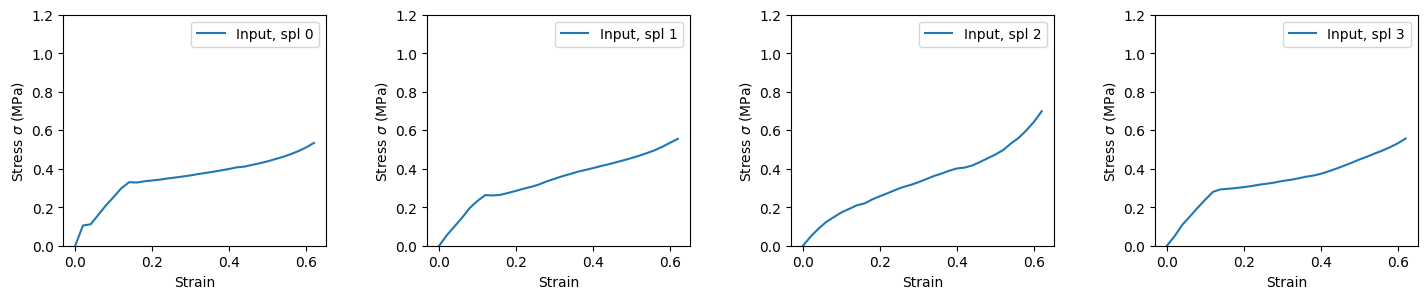

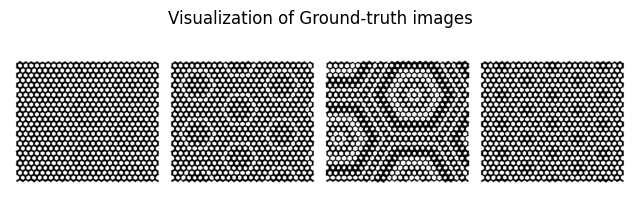

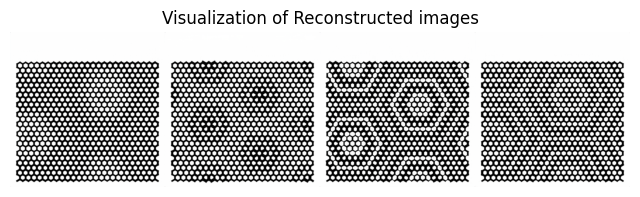

In [36]:
sample_loop    (model,
                test_loader ,
                cond_scales=[1],#list of cond scales - each sampled...
                num_samples=4, #how many samples produced every time tested.....
                flag=1000, plot_structure=True, plot_original_data=True,do_forward=False,
                strain=strain,
                number_batches=1, #How many batches are sampled
             )

Open CSV file to save... 301_test_2.csv
torch.Size([16, 32]) torch.Size([16, 3, 512, 512])
Producing 4 samples..., batch size =16


0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

torch.Size([16, 16, 64])
Save individual samples  ./Diffusion_results/recon_samples_8000_0_0.png
Save individual samples  ./Diffusion_results/recon_samples_8000_0_1.png
Save individual samples  ./Diffusion_results/recon_samples_8000_0_2.png
Save individual samples  ./Diffusion_results/recon_samples_8000_0_3.png


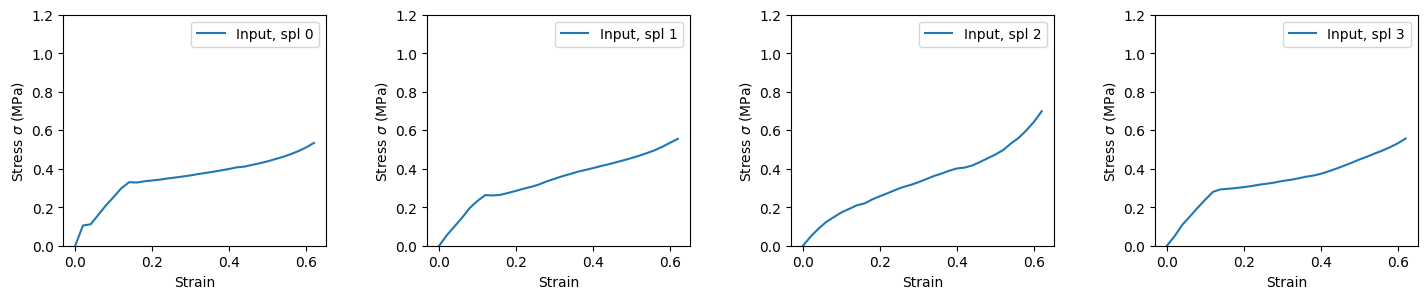

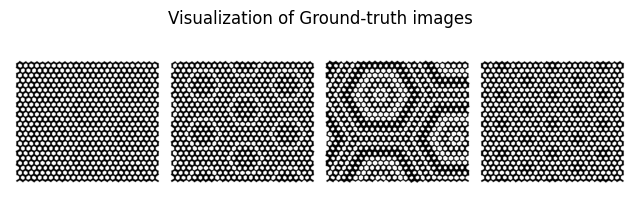

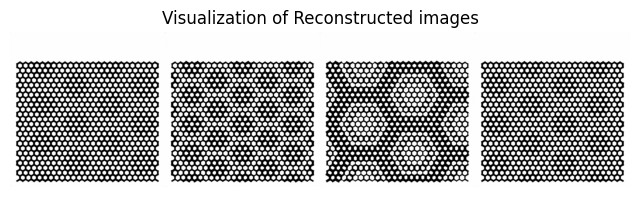

Now save CSF file: 301_test_2.csv
Now save CSF file: 301_test_2.csv


In [48]:
sample_loop (model,
                            test_loader ,
                            cond_scales=[1],# 
                            num_samples=4, #how many samples produced every time tested.....
                                    flag=8000, plot_structure=True, plot_original_data=True,do_forward=False,
             strain=strain,number_batches=1,save_ind_files=True,csv_for_data='301_test_2.csv' #stored results in CSV file
                                    )